# Workshop on vision based localization

Course: Spatial Reasoning from Sensor Data, https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor--data/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective

- The objective of this workshop is to perform place recognition and localization

## Reference

- Dataset: Scene recognition, https://www.cc.gatech.edu/~hays/compvision/proj4/. The place dataset is downloaded at https://www.cc.gatech.edu/~hays/compvision/proj4/data.zip
    
- This workshop code is modified from the original Caffe version in the following reference to be Keras version.

- Refrence: 'Benchmark for Image Retrieval (BKIR)', https://github.com/willard-yuan/cnn-cbir-benchmark



In [21]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
import tensorflow as tf

# Check GPU coinfiguration in Colab
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'


Tensorflow version:  2.15.0
/device:GPU:0


In [22]:
# Then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path and change XXX to be your own folder.
# The path is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/SRSD/Day2')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
archive   SRSD_Day2_wk_place_recognition_keras_yourname.ipynb
data	  SRSD_Day2_wk_place_recognition_pytorch_yourname.ipynb
data_old


## Prepare gallery images set and query images set

In [23]:
# Prepare the gallery folder and image file list
gallery_image_folder_name = 'data/scene/gallery'
gallery_image_file_list = []
gallery_image_class_list = sorted(os.listdir(gallery_image_folder_name))
for subfolder in gallery_image_class_list:
    file_list = sorted(os.listdir(gallery_image_folder_name + '/' + subfolder))
    for file in file_list:
        gallery_image_file_list.append(gallery_image_folder_name + '/' + subfolder + '/' + file)

print("Gallery: %d classes, %d images" % (len(gallery_image_class_list), len(gallery_image_file_list)))

# Prepare the query folder and image file list
query_image_folder_name = 'data/scene/query'
query_image_file_list = []
query_image_class_list = sorted(os.listdir(query_image_folder_name))
for subfolder in query_image_class_list:
    file_list = sorted(os.listdir(query_image_folder_name + '/' + subfolder))
    for file in file_list:
        query_image_file_list.append(query_image_folder_name + '/' + subfolder + '/' + file)

print("Query: %d classes, %d images" % (len(query_image_class_list), len(query_image_file_list)))


Gallery: 15 classes, 1500 images
Query: 15 classes, 150 images


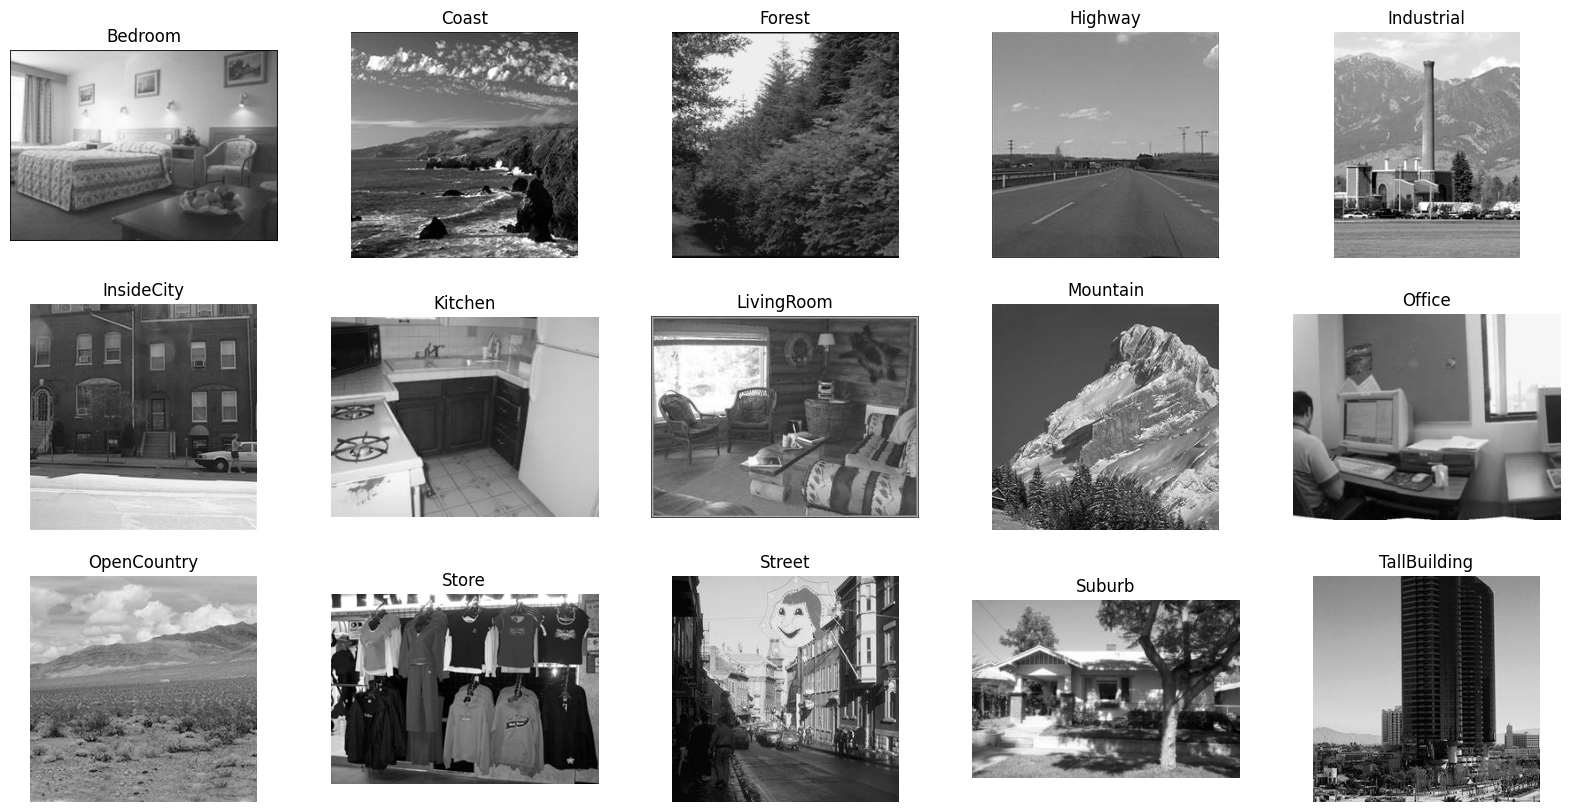

In [24]:
# Illustrate sample gallery images
gallery_image_folder_name = 'data/scene/gallery'
plt.figure(figsize=(20,10))
i = 0
for subfolder in gallery_image_class_list:
    file_list = os.listdir(gallery_image_folder_name + '/' + subfolder)
    for file in file_list:
        if '.jpg' in file:
            i = i+1
            plt.subplot(3, 5, i)
            plt.imshow(cv2.imread(gallery_image_folder_name + '/' + subfolder + '/' + file))
            plt.axis("off")
            plt.title(subfolder)
            break
plt.show()


In [25]:
# Compare the input query file name and the result file name lists to calculate the precision performance
# For example
# input_file_name: data/scene/gallery/Mountain/image_0076.jpg
# result_file_name_list: a list of top_return files in query results
# Precision: Number of true returned results/Total number of results
# Accuracy: 1: IF there is at least one true returned result; 0: All returned results are wrong

def cal_precision(input_file_name, result_file_name_list):
    num = 0
    input_class = input_file_name.split("/")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[3]
        if (input_class == result_class):
            num = num+1
    return (num/len(result_file_name_list))

def cal_accuracy(input_file_name, result_file_name_list):
    result = 0
    input_class = input_file_name.split("/")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[3]
        if (input_class == result_class):
            result = 1
            break
    return (result)

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)


## Neural Codes: Step 0, Define functions

- Reference: Artem Babenko, Anton Slesarev, Alexandr Chigorin, Victor Lempitsky, "Neural Codes for Image Retrieval," ECCV 2014, https://arxiv.org/abs/1404.1777

- Process
    - Extract `fc2` layer coefficients as the features
    - Apply cosine similarity (dot product) as the similarity score


In [26]:
# Define VGG baseline model
# The VGG model file (553 MB) will be downloaded from the Internet when you run this code for the first time.

vgg_model = vgg16.VGG16(weights='imagenet', include_top=True)
vgg_model.summary()

# Define VGG extracting fc2 layer coefficients
vgg_model_extract_fc2 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc2').output)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# A VGG model file (553 MB) will be downloaded from the Internet for the first time of running this code

def extract_vgg_fc_feature_from_list(image_file_list):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        if ((idx % 100) ==0 ):
            print("process %d/%d file" % (idx+1, len(image_file_list)))
        img = image.load_img(eachFile, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        fc2_features = vgg_model_extract_fc2.predict(x)
        fc2_features = fc2_features/np.linalg.norm(fc2_features) # normalzie features
        all_feature.append(fc2_features)
    return all_feature


## Neural Codes: Step 1, Feature extraction from from both gallerying and query data set

In [28]:
# # # Uncomment followings to re-calculate all features
# # Extract features from gallery images
# gallery_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(gallery_image_file_list)
# print("Dimension of gallery_all_feature_vgg_fc: (%d, %d)" % (len(gallery_all_feature_vgg_fc), gallery_all_feature_vgg_fc[0].shape[1]))
# np.save('data/gallery_all_feature_vgg_fc.npy', gallery_all_feature_vgg_fc)

# print('Extract features from query images')
# query_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(query_image_file_list)
# print("query_all_feature_vgg_fc: (%d, %d)" % (len(query_all_feature_vgg_fc), query_all_feature_vgg_fc[0].shape[1]))
# np.save('data/query_all_feature_vgg_fc.npy', query_all_feature_vgg_fc)


In [29]:
# Use the pre-calculated features provided in the workshop
gallery_all_feature_vgg_fc = np.load('data/gallery_all_feature_vgg_fc.npy')
query_all_feature_vgg_fc = np.load('data/query_all_feature_vgg_fc.npy')
print("gallery_all_feature_vgg_fc: (%d, %d)" % (len(gallery_all_feature_vgg_fc), gallery_all_feature_vgg_fc[0].shape[1]))
print("query_all_feature_vgg_fc: (%d, %d)" % (len(query_all_feature_vgg_fc), query_all_feature_vgg_fc[0].shape[1]))


gallery_all_feature_vgg_fc: (1500, 4096)
query_all_feature_vgg_fc: (150, 4096)


## Neural Codes: Step 2, Performance evaluation

In [30]:
##query and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(query_all_feature_vgg_fc)):
    dist_list = []
    for eachpic in range(len(gallery_all_feature_vgg_fc)):
        dist = cal_vec_dist(query_all_feature_vgg_fc[i], gallery_all_feature_vgg_fc[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image
    index = np.argsort(most_sim)[:top_return]
    input_file_name = query_image_file_list[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(gallery_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))

print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


Top 5 return, mean Precision: 0.7653
Top 5 return, mean Accuracy: 0.9333


## Neural Codes: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`) and perform instance search

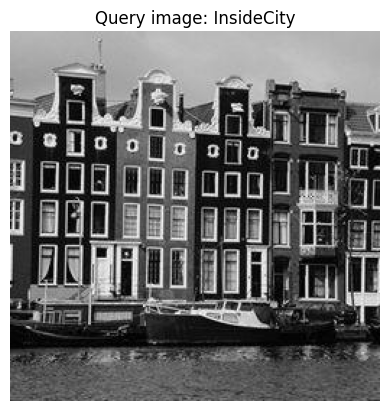

Query: data/scene/query/InsideCity/image_0029.jpg
Top 1 match: data/scene/gallery/InsideCity/image_0278.jpg, distance: 0.8334
Top 2 match: data/scene/gallery/InsideCity/image_0121.jpg, distance: 0.9185
Top 3 match: data/scene/gallery/InsideCity/image_0281.jpg, distance: 0.9269
Top 4 match: data/scene/gallery/TallBuilding/image_0110.jpg, distance: 0.9444
Top 5 match: data/scene/gallery/TallBuilding/image_0274.jpg, distance: 0.9474


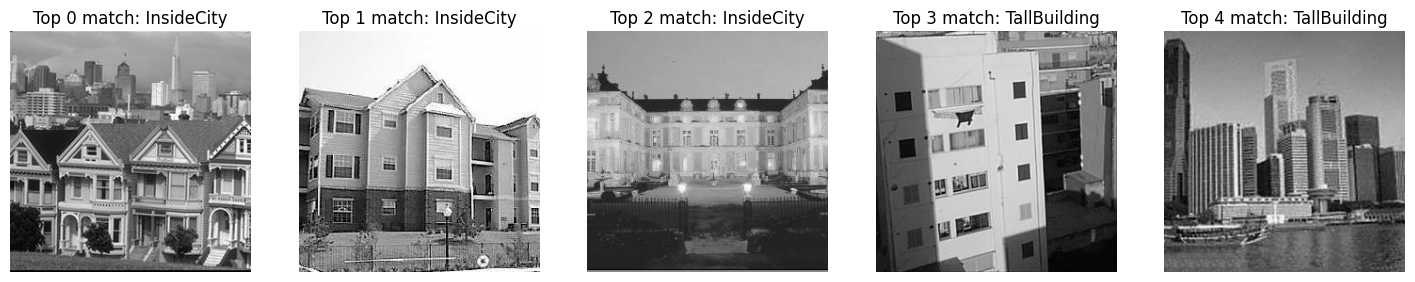

In [31]:
# query and evaluation
dist_list = []
display_random_numer = random.randint(0, len(query_image_file_list)-1)
for eachpic in range(len(gallery_all_feature_vgg_fc)):
    dist = cal_vec_dist(query_all_feature_vgg_fc[display_random_numer], gallery_all_feature_vgg_fc[eachpic])
    dist_list.append(dist)

# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(query_image_file_list[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + query_image_file_list[display_random_numer].split("/")[3])
plt.show()

print("Query: %s" % (query_image_file_list[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(gallery_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + gallery_image_file_list[index[i]].split("/")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, gallery_image_file_list[index[i]], dist_array[index[i]]))
plt.show()

## Global pooling: Step 0, Define functions

- Reference: `Global sum-pooling`, Artem Babenko, Victor Lempitsky, "Aggregating Deep Convolutional Features for Image Retrieval," ICCV 2015, https://arxiv.org/abs/1510.07493
    
- Process
    - Extract `block5_conv3` layer coefficients, then apply either global sum-pooling or max-pooling to generate features.
    - Apply cosine similarity (dot product) as the similarity score
    

In [32]:
# Define VGG extracting block5_conv3 layer coefficients
vgg_model_extract_blk5conv3 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv3').output)


In [33]:

def extract_vgg_conv_feature_from_list(image_file_list, mode='sum'):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):

        img = image.load_img(eachFile, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        conv_features = vgg_model_extract_blk5conv3.predict(x)
        if (mode == 'sum'):
            conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        else:
            print('extract_vgg_conv_feature_from_list: Wrong mode as input')
            break
        all_feature.append(conv_features)
    return all_feature


## Global pooling: Step 1, Feature extraction from from both gallery and query data set

In [34]:
# # # Uncomment followings to re-calculate all features
# # Extract features from gallery images
# gallery_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(gallery_image_file_list, 'sum')
# np.save('data/gallery_all_feature_vgg_conv.npy', gallery_all_feature_vgg_conv)
# print("gallery_all_feature_vgg_conv: (%d, %d)" % (len(gallery_all_feature_vgg_conv), gallery_all_feature_vgg_conv[0].shape[1]))

# # Extract features from query images, get all the descriptor vectors of the whole query data set

# print('Extract features from query images')
# query_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(query_image_file_list)
# print("query_all_feature_vgg_conv: (%d, %d)" % (len(query_all_feature_vgg_conv), query_all_feature_vgg_conv[0].shape[1]))
# np.save('data/query_all_feature_vgg_conv.npy', query_all_feature_vgg_conv)


In [35]:
# Use the pre-calculated features provided in the workshop

gallery_all_feature_vgg_conv = np.load('data/gallery_all_feature_vgg_conv.npy')
query_all_feature_vgg_conv = np.load('data/query_all_feature_vgg_conv.npy')
print("gallery_all_feature_vgg_conv: (%d, %d)" % (len(gallery_all_feature_vgg_conv), gallery_all_feature_vgg_conv[0].shape[1]))
print("query_all_feature_vgg_conv: (%d, %d)" % (len(query_all_feature_vgg_conv), query_all_feature_vgg_conv[0].shape[1]))


gallery_all_feature_vgg_conv: (1500, 512)
query_all_feature_vgg_conv: (150, 512)


## Global pooling: Step 2, Performance evaluation

In [36]:
##query and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(query_all_feature_vgg_conv)):
    dist_list = []
    if ((i % 200) ==0 ):
        print("process %d/%d file" % (i+1, len(query_all_feature_vgg_conv)))
    for eachpic in range(len(gallery_all_feature_vgg_conv)):
        dist = cal_vec_dist(query_all_feature_vgg_conv[i], gallery_all_feature_vgg_conv[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image
    index = np.argsort(most_sim)[:top_return]
    input_file_name = query_image_file_list[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(gallery_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))

print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


process 1/150 file
Top 5 return, mean Precision: 0.7320
Top 5 return, mean Accuracy: 0.9200


## Global pooling: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`).
- Calculate the distance between the query data `query_all_feature_vgg_conv[display_random_numer]` and all gallery data feature `gallery_all_feature_vgg_conv`.
- Sort the distance matrix and pick up the top return `top_return`.
- Visualize the query image, the top return images and their distances (smaller distances indicate higher similarity).

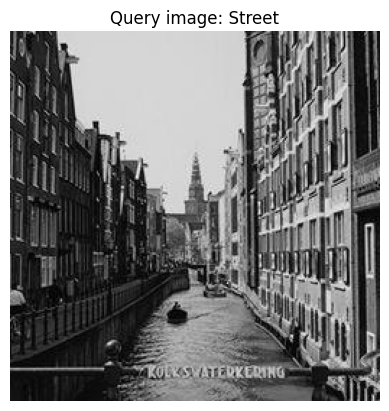

Query: data/scene/query/Street/image_0006.jpg
Top 1 match: data/scene/gallery/Street/image_0228.jpg, distance: 0.6265
Top 2 match: data/scene/gallery/Street/image_0130.jpg, distance: 0.6548
Top 3 match: data/scene/gallery/Street/image_0002.jpg, distance: 0.6807
Top 4 match: data/scene/gallery/Street/image_0015.jpg, distance: 0.7029
Top 5 match: data/scene/gallery/TallBuilding/image_0247.jpg, distance: 0.7241


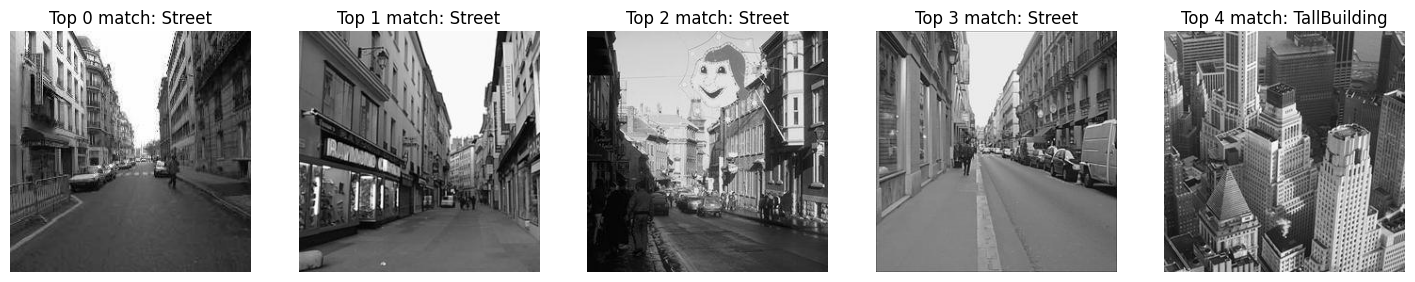

In [37]:

dist_list = []
display_random_numer = random.randint(0, len(query_image_file_list)-1)
for eachpic in range(len(gallery_all_feature_vgg_conv)):
    dist = cal_vec_dist(query_all_feature_vgg_conv[display_random_numer], gallery_all_feature_vgg_conv[eachpic])
    dist_list.append(dist)

# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(query_image_file_list[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + query_image_file_list[display_random_numer].split("/")[3])
plt.show()

print("Query: %s" % (query_image_file_list[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(gallery_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + gallery_image_file_list[index[i]].split("/")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, gallery_image_file_list[index[i]], dist_array[index[i]]))
plt.show()


$\color{red}{\text{Discussions}}$

Q1: The place recognition method is studied in this workshop. After the location (e.g., auditorium) is recognized, how can we further recognize a more detailed location (e.g., stage or front door of the auditorium)? Describe your solution and state additional data required (if any).

Q2: How do you want to revise the pretrained CNN-based feature to further get local details of the image?

In [38]:
# Provide your solution to Q1 here
#
#
# Provide your solution to Q2 here
#
#

**After you finish the workshop, rename and submit your .ipynb file.**